In [1]:
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

from sklearn.calibration import CalibratedClassifierCV, calibration_curve

In [2]:
def bin_data(y, n_bins):
    """
    Partitions the data into ordered bins based on
    the probabilities. Returns the binned indices.
    """
    edges = np.linspace(0, 1, n_bins)
    bin_idx = np.digitize(y, edges, right=True)
    binned_idx = [np.where(bin_idx == i)[0] for i in range(n_bins)]
    
    return binned_idx
    
def bin_stats(y_true, y_proba, bin_idx=None, n_bins=10):
    if not bin_idx:
        bin_idx = bin_data(y_proba.max(axis=1), n_bins)
    # mean accuracy within each bin
    bin_acc = [
        np.equal(np.argmax(y_proba[idx], axis=1), y_true[idx]).mean() if len(idx) > 0 else 0
        for idx in bin_idx
    ]
    # mean confidence of prediction within each bin
    bin_conf = [
        np.mean(np.max(y_proba[idx], axis=1)) if len(idx) > 0 else 0
        for idx in bin_idx 
    ]
    
    return np.asarray(bin_acc), np.asarray(bin_conf)

def ece(y_true, y_proba, n_bins=10):
    bin_idx = bin_data(y_proba.max(axis=1), n_bins)
    n = len(y_true)
    
    bin_acc, bin_conf = bin_stats(y_true, y_proba, bin_idx)
    bin_sizes = [len(idx) for idx in bin_idx]
    
    ece = np.sum(np.abs(bin_acc - bin_conf) * np.asarray(bin_sizes)) / n
    
    return ece

def mce(y_true, y_proba, n_bins=10):
    bin_idx = bin_data(y_proba.max(axis=1), n_bins)
    
    bin_acc, bin_conf = bin_stats(y_true, y_proba, bin_idx)
    mce = np.max(np.abs(bin_acc - bin_conf))
    
    return mce

def brier_score_mvloss(y_true, y_proba):
    if y_true.ndim == 1:
        y_true = np.squeeze(np.eye(len(np.unique(y_true)))[y_true.reshape(-1)])
    return np.mean(
        np.mean((y_proba - y_true)**2, axis=1)
    )

In [3]:
clfs = ['RF', 'IRF', 'SigRF', 'UF']
color_dict = {
    'UF': '#e41a1c',
    'RF': '#377eb8',
    'SigRF': '#4daf4a',
    'IRF': '#984ea3',
}

In [4]:
def _bin_scores_from_fold(y_true, y_proba, n_bins):
    bin_idx = bin_data(y_proba.max(axis=1), n_bins)
    n = len(y_true)
    
    bin_acc, bin_conf = bin_stats(y_true, y_proba, bin_idx)
    bin_sizes = np.asarray([len(idx) for idx in bin_idx])
    
    ece = np.sum(np.abs(bin_acc - bin_conf) * bin_sizes) / n
    
    return ece, bin_acc, bin_sizes

def get_bin_scores(results_dir='./results_cv10/', n_bins=10):
    tasks = []
    task_bin_accs = []
    task_bin_eces = []
    task_bin_sizes = []
    for file in os.listdir(results_dir):
        with open(results_dir + file, 'rb') as f:
            results_dict = pickle.load(f)
        
        clf_accs = []
        clf_eces = []
        clf_bin_sizes = []
        for name in clfs:
            stats = [_bin_scores_from_fold(
                results_dict['y'][idx], y_proba, n_bins
            ) for y_proba, idx in zip(results_dict[name], results_dict['test_indices'])]
            eces, bin_accs, bin_sizes = list(zip(*stats))
            clf_accs.append(np.mean(bin_accs, axis=0))
            clf_eces.append(np.mean(eces))
            clf_bin_sizes.append(np.mean(bin_sizes, axis=0))
            # clf_bin_sizes.append(np.hstack([y_proba.max(1) for y_proba in results_dict[name]]))
        
        tasks.append(
            {k: results_dict[k] for k in ['task_id', 'task', 'n_samples', 'n_classes', 'n_features']
            })
        task_bin_accs.append(clf_accs)
        task_bin_eces.append(clf_eces)
        task_bin_sizes.append(clf_bin_sizes)

    return tasks, task_bin_accs, task_bin_eces, task_bin_sizes

In [5]:
tasks, task_bin_accs, task_eces, task_bin_sizes = get_bin_scores()

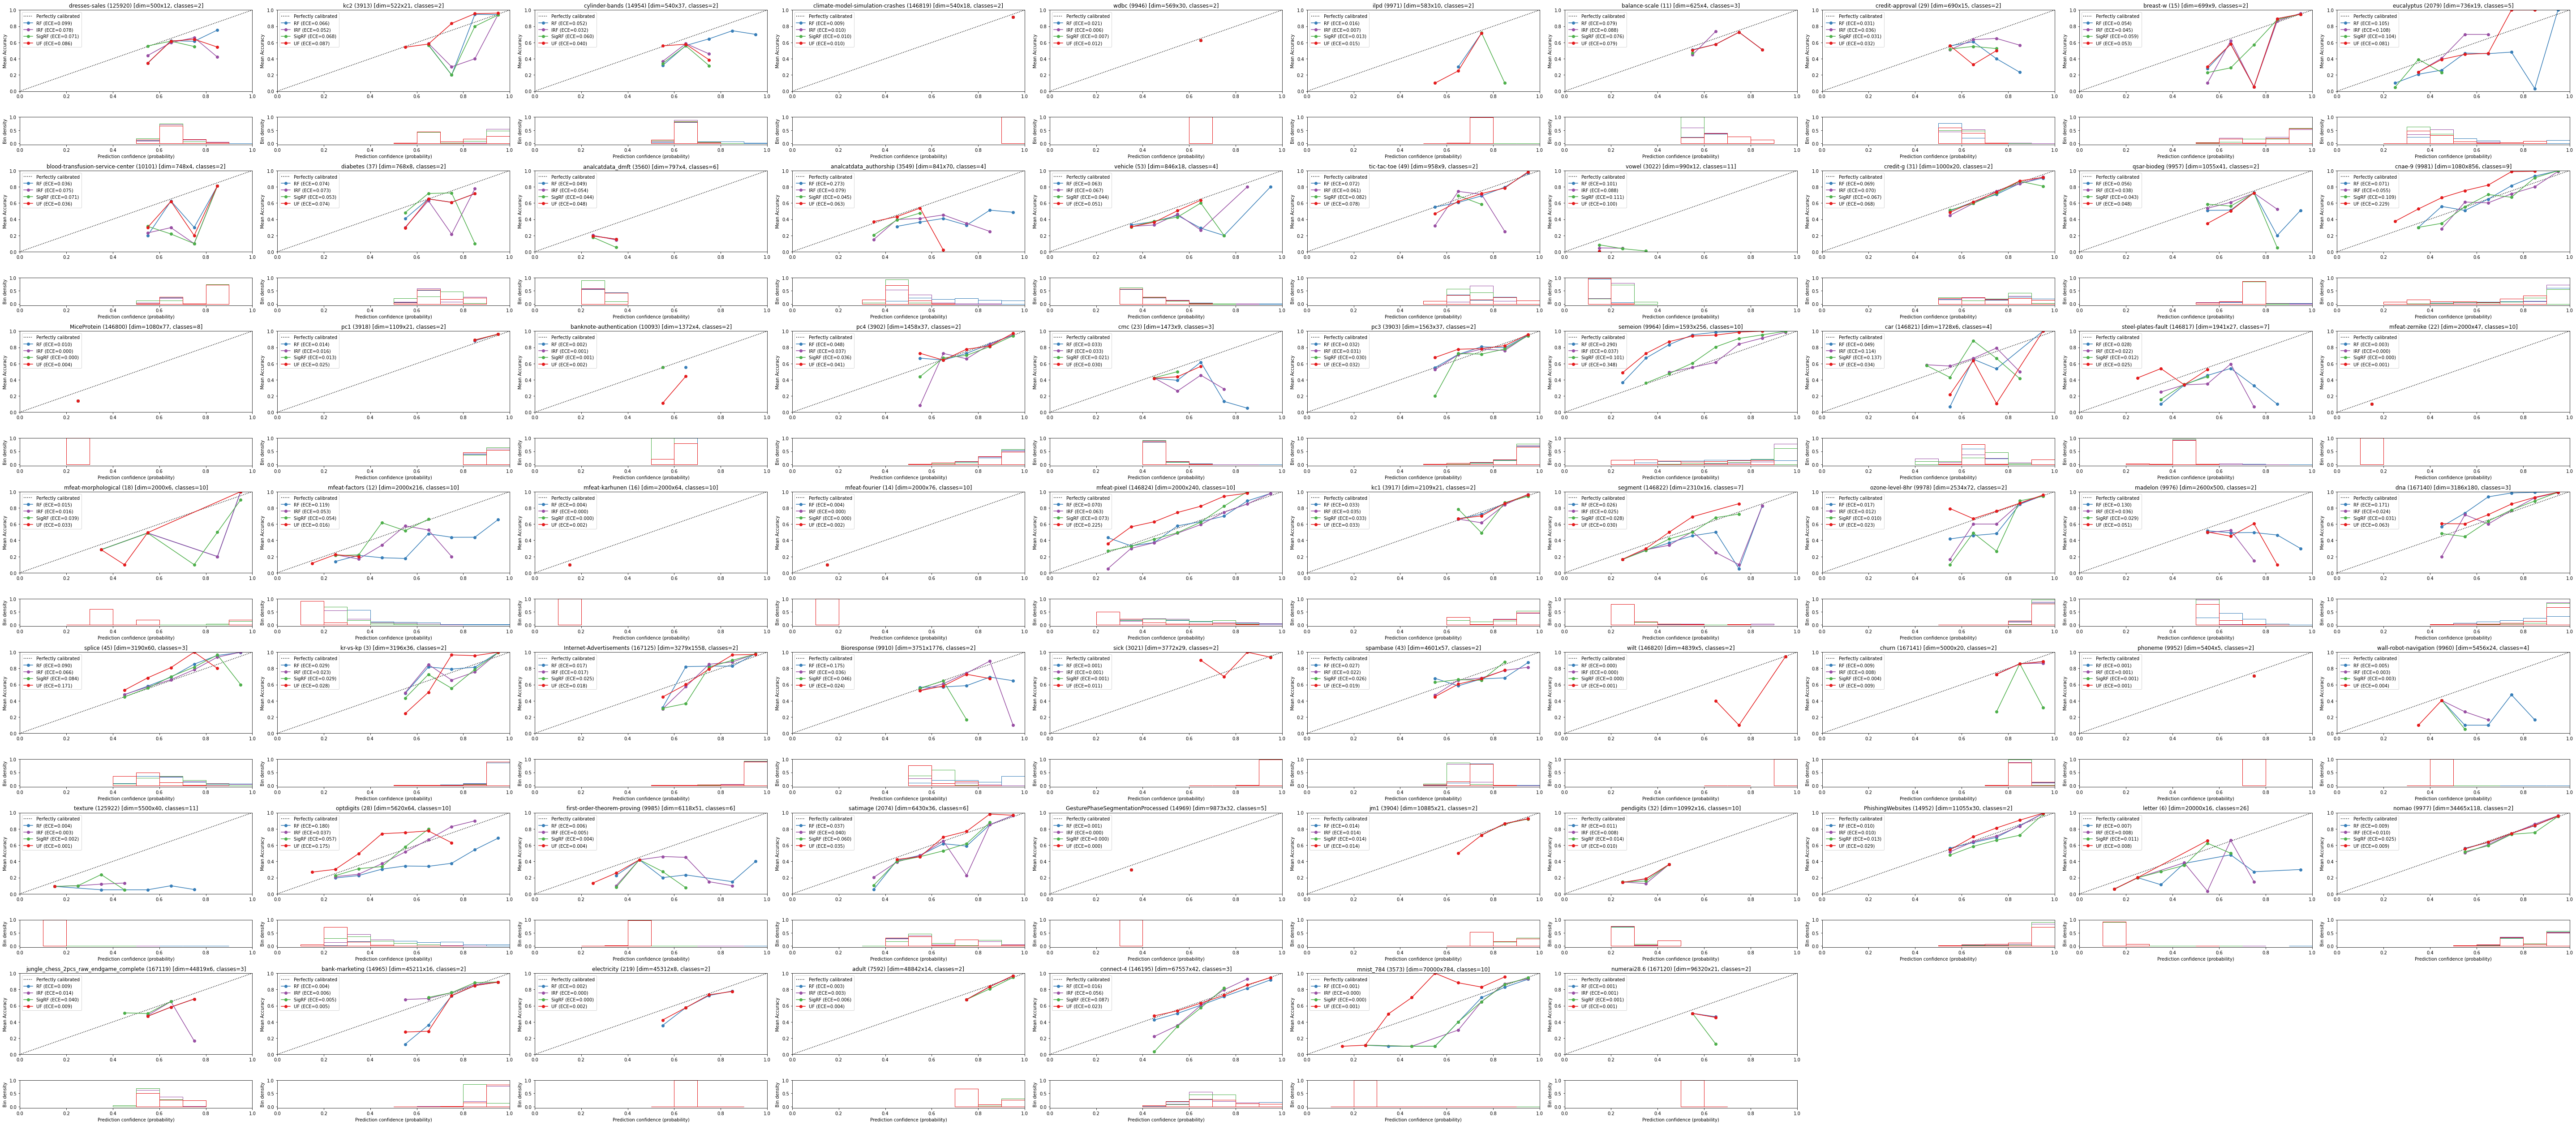

In [7]:
n_rows = 7
n_cols = 10
plt.rcParams['figure.facecolor'] = 'white'
fig = plt.figure(figsize=(8*n_cols, 5*n_rows))

samples_sizes = sorted(
    [(i, task['n_samples']) for i, task in enumerate(tasks)],
    key=lambda x: x[1])

n_bins = 10
bin_centers = np.linspace(0.05, 0.95, n_bins)

for rc, (idx, _) in enumerate(samples_sizes):
    row = rc // n_cols
    col = rc % n_cols
    
    ax1 = plt.subplot2grid((3*n_rows, 1*n_cols), (row*3, col), rowspan=2)
    ax2 = plt.subplot2grid((3*n_rows, 1*n_cols), (2+row*3, col))

    # fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 5))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

    bin_accs = task_bin_accs[idx]
    eces = task_eces[idx]
    bin_sizes = task_bin_sizes[idx]
    task = tasks[idx]
    task_name = task['task']
    task_id = task['task_id']
    n_samples = task['n_samples']
    n_classes = task['n_classes']
    n_features = task['n_features']

    # Initialize network
    for i, clf in enumerate(clfs):
        accs = bin_accs[i]
        ax1.plot(bin_centers[accs > 0], accs[accs > 0], "o-", label=f'{clf} (ECE={eces[i]:.3f})', c=color_dict[clf])

#         ax1.bar(
#             bin_centers, accs, width=0.1, label=f'{clf} (ECE={eces[i]:.3f})', ec=color_dict[clf], fill=False
#         )

        sizes = bin_sizes[i]
        ax2.bar(
            bin_centers[sizes > 0],
            sizes[sizes > 0] / np.sum(sizes),
            width=0.1,
            alpha=1,
            label=clf,
            fill=False,
            ec=color_dict[clf])

    ax1.set_ylabel("Mean Accuracy")
    ax1.set_ylim([0, 1])
    ax1.set_xlim([0, 1])
    ax2.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax1.legend(loc="upper left")
    ax1.set_title(f'{task_name} ({task_id}) [dim={n_samples}x{n_features}, classes={n_classes}]')

    ax2.set_xlabel("Prediction confidence (probability)")
    ax2.set_ylim([-0.05, 1])
    ax2.set_xlim([0, 1])
    ax2.set_yticks([0, 0.5, 1])
    ax2.set_ylabel("Bin density")

plt.tight_layout()
plt.savefig('./figures/ece_density_plots_cv10.pdf', dpi=300)
plt.show()